In [13]:
## IMPORTANT: On Colab, we expect your homework to be in the cs189 folder
## Please contact staff if you encounter any problems with installing dependencies
import sys
IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/cs189/hw/hw1
    %pip install -r ./requirements.txt
    !pip install -U kaleido plotly
    import kaleido
    kaleido.get_chrome_sync()

import plotly.io as pio
pio.renderers.default = pio.renderers.default + "+png"


In [12]:
# Initialize Otter
import otter
grader = otter.Notebook("fashion_pt_2.ipynb")

<link rel="stylesheet" href="berkeley.css">

<h1 class="cal cal-h1">Homework 1.2 – AGI, Everywhere, All at Once</h1>

Welcome to Homework 1.2! In this assignment, you will build on the foundational skills you developed in part 1. You will gain hands-on experience with building and evaluating machine learning models, debugging performance issues, and exploring strategies to improve model accuracy. By the end of this assignment, you will have a deeper understanding of how to work with classifiers and analyze their performance.

---

## Due Date: Friday, September 26, 11:59 PM

This assignment is due on **Friday, September 26, at 11:59 PM**. You must submit your work to Gradescope by this deadline. Please refer to the syllabus for the [Slip Day policy](https://eecs189.org/fa25/syllabus/#slip-days). No late submissions will be accepted beyond the details outlined in the Slip Day policy.

### Submission Tips:
- **Plan ahead**: We strongly encourage you to submit your work several hours before the deadline. This will give you ample time to address any submission issues.
- **Reach out for help early**: If you encounter difficulties, contact course staff well before the deadline. While we are happy to assist with submission issues, we cannot guarantee responses to last-minute requests.

---

## Assignment Overview

This notebook contains a series of tasks designed to help you practice and apply key concepts in machine learning. You will complete all the TODOs in the notebook, which include both coding and written response questions. Some tasks are open-ended, which allows you to explore and experiment with different approaches.

### Key Learning Objectives:
1. Build and evaluate machine learning classifiers.
2. Debug and analyze model performance.
3. Explore techniques to improve accuracy.
4. Gain experience with tools like `numpy`, `pandas`, `plotly`, and `scikit-learn`.

---

<div align="center">

### Grading Breakdown

| Question | Manual Grading? | Points |
|----------|-----------------|--------|
| 5a       | No              | 2      |
| 5b       | No              | 4      |
| 5c       | No              | 1      |
| 5d       | Yes             | 2      |
| 6a       | No              | 3      |
| 6b       | Yes             | 2      |
| 6c       | No              | 1      |
| 6d       | Yes             | 1      |
| 7a       | No              | 3      |
| 7b       | Yes             | 3      |
| 8a       | Yes             | 3      |
| 8b       | No              | 3      |
| 8c       | No              | 5      |
| 8d       | Yes             | 1      |
| 9a       | No              | 5      |
| **Total**|                 | **39** |

</div>

**Note**: "Manual" questions are written response questions that will be graded manually by the course staff. All other questions will be graded automatically by the autograder.

---

### Instructions:
1. Carefully read each question and its requirements.
2. Complete all TODOs in the notebook. You may add extra lines of code if needed to implement your solution.
3. For manual questions, provide clear and concise written responses.
4. Test your code thoroughly to ensure it meets the requirements.

Good luck!

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import torchvision
import os
from scipy.ndimage import rotate
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import joblib  # For saving/loading the model

pd.options.plotting.backend = "plotly"

### **IMPORTANT:** 
- Do not change the random seed values!!!
- Before you submit your notebook, remember to set `save_models=True` and `load_models=True`. This saves your final models which we will use for the autograder. Set these to false if you are still tweaking your model setup. We have provided code for saving models - **do not change these file names!!**
- When uploading your notebook, make sure to include your model file `classifier.joblib` in your submission

In [2]:
# Set random seeds for reproducible results
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# IMPORTANT: set save_models to True to save trained models. YOU NEED TO DO THIS FOR THE AUTOGRADER TO WORK.
save_models = True
load_saved_models = True # After training, you can set this to True to load the saved models and not have to re-train them.
IS_GRADING_ENV = os.getenv("IS_GRADING_ENV") == "true"

In [3]:
# Importing helper function to show images
def show_images(images, max_images=40, ncols=5, labels = None, reshape=False):
    """Visualize a subset of images from the dataset.
    Args:
        images (np.ndarray or list): Array of images to visualize [img,row,col].
        max_images (int): Maximum number of images to display.
        ncols (int): Number of columns in the grid.
        labels (np.ndarray, optional): Labels for the images, used for facet titles.
    Returns:
        plotly.graph_objects.Figure: A Plotly figure object containing the images.
    """
    if isinstance(images, list):
        images = np.stack(images)
    n = min(images.shape[0], max_images) # number of images to show
    px_height = 220 # height of each image in pixels
    if reshape:
        images = images.reshape(images.shape[0], 28, 28)
    fig = px.imshow(images[:n, :, :], color_continuous_scale='gray_r', 
                    facet_col = 0, facet_col_wrap=ncols,
                    height = px_height * int(np.ceil(n/ncols)))
    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(showticklabels=False, showgrid=False)
    fig.update_yaxes(showticklabels=False, showgrid=False)
    if labels is not None:
        # Extract the facet number and replace with the label.
        fig.for_each_annotation(lambda a: a.update(text=labels[int(a.text.split("=")[-1])]))
    return fig

## Load the Fashion-MNIST Dataset  

Let's reload the Fashion-MNIST dataset. As a reminder, this dataset contains 70k images (60k training, 10k testing) of 28x28 grayscale images of clothing divided into the following 10 classes:
1. **T-shirt/top**
2. **Trouser**
3. **Pullover**
4. **Dress**
5. **Coat**
6. **Sandal**
7. **Shirt**
8. **Sneaker**
9. **Bag**
10. **Ankle boot**

### Dataset Structure:
- **Images**: Each image is represented as a 28x28 grayscale matrix, where each value corresponds to the pixel intensity.
- **Targets**: Each image is associated with a label (0-9), which maps to one of the 10 classes listed above.

### Data Preparation:
In the code cell below, we:
1. Load the Fashion-MNIST training dataset using `torchvision.datasets.FashionMNIST`.
2. Extract the images and targets into `NumPy` arrays for easier manipulation.
3. Create a `pandas DataFrame` (`df`) to store the images and their corresponding labels. 

In [5]:
# Load the FashionMNIST training dataset
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
images = train_data.data.numpy().astype(float)  # Convert images to numpy array
targets = train_data.targets.numpy()  # Extract labels
class_dict = {i:class_name for i,class_name in enumerate(train_data.classes)}
labels = np.array([class_dict[t] for t in targets])  # Map labels to class names
n = len(images)  # Total samples
class_names = list(class_dict.values())
print(f"Loaded FashionMNIST with {n} samples. Classes: {class_dict}")
print("Classes: {}".format(class_dict))
print("Image shape: {}".format(images[0].shape))
print("Image dtype: {}".format(images[0].dtype))


# Creating a DataFrame with the images and labels
df = pd.DataFrame({"image": images.tolist(), "label": labels})
# Cast image as numpy array
df['image'] = df['image'].apply(lambda x: np.array(x).reshape(-1))

Loaded FashionMNIST with 60000 samples. Classes: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
Classes: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
Image shape: (28, 28)
Image dtype: float64


### (Training) Fitting a Classifier

Just like in part 1, let's train a 2-layer MLP classifier on the original data and see how it performs.

**Task:** Copy and paste your code from part 1 (problem 3c). 

Below is the reminder about the process for training any model that will follow in the next question:

### Steps:
1. **Split the Data**: Use [scikit-learn `train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to divide the dataset into training and testing subsets.
2. **Standardize the Features**: Use [scikit-learn `StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the pixel values of the images.
3. **Train the Classifier**: Use [scikit-learn `MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to train a neural network on the training data.
4. **Evaluate the Model**: Measure the model's accuracy on both the training and testing datasets.

**Why Train-Test Split?**
We split the dataset into training and testing subsets to evaluate the model's performance on unseen data. This helps us evaluate the model's generalization capability.

**Why Standardize the Data?**
Standardization scales the input features to have zero mean and unit variance. This helps the MLP converge faster during training and improves the stability of the optimization process.

Useful docs:
* [scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* [scikit-learn MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
* [scikit-learn Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [6]:
# Split the dataset into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# Extract image data and labels for training and testing
X_train = np.stack(train_df['image'].to_numpy())  # Training images
X_test = np.stack(test_df['image'].to_numpy())    # Testing images
y_train = train_df['label'].to_numpy()            # Training labels
y_test = test_df['label'].to_numpy()              # Testing labels

# Print the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (48000, 784)
X_test shape: (12000, 784)


In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import joblib  # for saving the model

if (load_saved_models or IS_GRADING_ENV) and os.path.exists('mlp_fashionmnist_model.joblib'):
    model = joblib.load("mlp_fashionmnist_model.joblib")
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
else:
    # TODO: paste your training code from part 1 (problem 3c) here setting random_state=SEED
    # BEGIN SOLUTION
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, tol=1e-3, random_state=SEED)
    model.fit(X=X_train_sc, y=y_train)

    # Plot loss curve using plotly express
    loss_df = pd.DataFrame({
        'epoch': range(1, len(model.loss_curve_) + 1),
        'loss': model.loss_curve_
    })
    loss_df.plot(x='epoch', y='loss', title="Training Error")
    # END SOLUTION
if save_models:
    # Save the trained model and scaler to disk
    joblib.dump(model, "mlp_fashionmnist_model.joblib")
    print("Model and scaler saved to disk.")

train_df['predicted_label'] = model.predict(X_train_sc)
test_df['predicted_label'] = model.predict(X_test_sc)

train_df['correct'] = train_df['predicted_label'] == train_df['label']
test_df['correct'] = test_df['predicted_label'] == test_df['label']

print(f"Training accuracy: {train_df['correct'].mean():.3f}")
print(f"Test accuracy: {test_df['correct'].mean():.3f}")

Model and scaler saved to disk.
Training accuracy: 0.496
Test accuracy: 0.491


## Problem 5: Regression Analysis

In this section, we will switch from classification to regression. The goal is to predict the price of clothing items based on their image features. Follow the steps below to load the price data, train a regression model, and evaluate its performance.

### Problem 5a: Training a Linear Regression Model

**Task**: Use `pandas` and `scikit-learn` to train a linear regression model to predict prices:

1. **Join the DataFrames**: 
    - Combine the price data with the original `train_df` and `test_df` using the [`join`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) method.
    - Store the resulting training data in `prices_train` and the testing data in `prices_test`.

    **Hint**: Think about which column can serve as the key for joining the `prices` DataFrame with the original `train_df` and `test_df`.

2. **Train the Model**:
    - Use `LinearRegression` from [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/linear_model.html) to train a regression model.
    - Ensure that the model predicts only positive prices.

3. **Store Predictions**:
    - Add the predicted prices to the `prices_test` `DataFrame`.

**Important for grading**: Name your model `price_model`.

**Expected Output**:
The `prices_train` and `prices_test` `DataFrames` should look like this:

| key_0 |      image      |    label    | predicted_label | correct | Price |
|-------|-----------------|-------------|-----------------|---------|-------|
| 48572 | [0.0, 0.0, ...] |   Sneaker   |     Sneaker     |   True  | 49.86 |
| 38696 | [0.0, 0.0, ...] |    Dress    |      Dress      |   True  | 14.56 |

In [9]:
prices = pd.read_csv("./data/FashionMNIST_prices.csv")
# TODO: Join the original `train_df` and `test_df` with the `prices` DataFrame
# Prices DataFrame has index as the key, so we need to set index for join
prices_with_index = prices.copy()
prices_with_index.index.name = 'key_0'

# Join train_df and test_df with prices using index
prices_train = train_df.join(prices_with_index, how='left')
prices_test = test_df.join(prices_with_index, how='left')

prices_train['Price'].hist().show()
prices_train.head()

,image,label,predicted_label,correct,Price
48572,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sneaker,Sneaker,True,49.86
38696,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Dress,Sandal,False,14.56
13611,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,Sandal,True,211.99
35213,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Bag,Dress,False,498.13
31766,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 57.0,...",Shirt,Coat,False,82.48


In [10]:
# TODO: Fit a linear regression model (price_model) on the training data with prices as the target variable
if (load_saved_models or IS_GRADING_ENV) and os.path.exists('price_model.joblib'):
    price_model = joblib.load('price_model.joblib')
    print("Model loaded from price_model.joblib")
else:
    # Train linear regression model
    price_model = LinearRegression()
    price_model.fit(X_train_sc, prices_train['Price'])
    print("Model trained")

# TODO: Predict the prices of the test data and add them to the test_df
prices_test['price_prediction'] = price_model.predict(X_test_sc)
# Ensure predictions are positive
prices_test['price_prediction'] = np.maximum(prices_test['price_prediction'], 0)

if save_models:
    joblib.dump(price_model, 'price_model.joblib')
    print("Model saved to price_model.joblib")

Model trained
Model saved to price_model.joblib


In [14]:
grader.check("q5a")

q5a results: All test cases passed!

### Problem 5b: Evaluate Linear Regression Performance

**Task**: Use `NumPy` operations to evaluate the performance of the linear regression model:

1. Calculate the **Root Mean Squared Error (RMSE)** to measure the average magnitude of prediction errors.

2. Calculate the **Mean Absolute Error (MAE)** to measure the average absolute difference between predicted and actual values.

3. Calculate the **R-squared score (R²)** to assess how well the model explains the variance in the data.

=== Training Metrics ===
RMSE: 57.85
MAE: 40.03
R²: 0.763
=== Test Metrics ===
RMSE: 59.98
MAE: 41.12
R²: 0.736


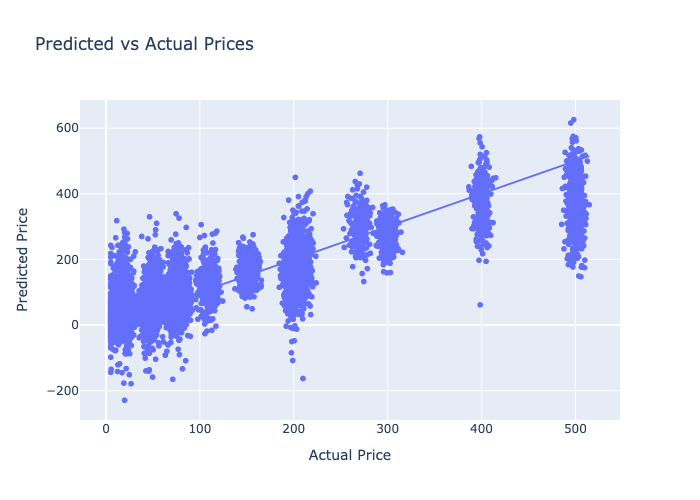

In [15]:
def compute_rmse(y_true, y_pred):
  """Compute Root Mean Squared Error"""
  mse = np.mean((y_true - y_pred) ** 2)
  return np.sqrt(mse)


def compute_mae(y_true, y_pred):
  """Compute Mean Absolute Error"""
  return np.mean(np.abs(y_true - y_pred))


def compute_r2(y_true, y_pred):
  """Compute R-squared score"""
  ss_res = np.sum((y_true - y_pred) ** 2)
  ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
  return 1 - (ss_res / ss_tot)

def print_metrics(y_true, y_pred, dataset=""):
  """Print all regression metrics for a dataset"""
  rmse = compute_rmse(y_true, y_pred)
  mae = compute_mae(y_true, y_pred)
  r2 = compute_r2(y_true, y_pred)

  print(f"=== {dataset} Metrics ===")
  print(f"RMSE: {rmse:.2f}")
  print(f"MAE: {mae:.2f}")
  print(f"R²: {r2:.3f}")
  return rmse, mae, r2

# Calculate predictions
y_train_pred = price_model.predict(X_train_sc)
y_test_pred = price_model.predict(X_test_sc)

# Compute and print metrics
train_rmse, train_mae, train_r2 = print_metrics(prices_train['Price'], y_train_pred, "Training")
test_rmse, test_mae, test_r2 = print_metrics(prices_test['Price'], y_test_pred, "Test")

# Visualize predictions vs actual
fig = px.scatter(
    x=prices_test['Price'],
    y=y_test_pred,
    title='Predicted vs Actual Prices',
    labels={'x': 'Actual Price', 'y': 'Predicted Price'}
)
fig.add_trace(px.line(x=[prices_test['Price'].min(), prices_test['Price'].max()], 
                      y=[prices_test['Price'].min(), prices_test['Price'].max()]).data[0])
fig.show()

In [16]:
grader.check("q5b")

q5b results: All test cases passed!

### Problem 5c: MAE, MSE, and R-Squared

**Question:** What are the advantages of using MAE over MSE to measure a model's performance? What are the advantages of using MSE over MAE to measure a model's performance?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question**: What does R-squared measure? Why is it significant?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Problem 5d: Relationship Between Classification and Regression Errors

**Task**: Analyze the relationship between classification and regression errors:
1. For each test sample, calculate the price prediction error and the relative price prediction error:
   - Add the following columns to `prices_test`:
     - `price_error`: The absolute difference between the predicted price and the actual price.
     - `price_error_relative`: The relative error, calculated as the absolute error divided by the actual price.
2. Compute and print:
   - `misclassified_price_error`: The average relative price error for misclassified images.
   - `correctly_classified_price_error`: The average relative price error for correctly classified images.

**Hints**:
- Use `np.abs` to calculate the absolute value of the price error.
- Divide the price error by the actual price to compute the relative price error.

In [17]:
# TODO: Compare how accurate the model is at classifying the images vs how accurate it is at predicting the price of the images
# TODO: Calculate the average relative price error for correctly classified vs. misclassified images

# Calculate price error and relative price error
prices_test['price_error'] = np.abs(prices_test['price_prediction'] - prices_test['Price'])
prices_test['price_error_relative'] = prices_test['price_error'] / prices_test['Price']

# Calculate average relative price error for misclassified and correctly classified images
misclassified_price_error = prices_test[~prices_test['correct']]['price_error_relative'].mean()
correctly_classified_price_error = prices_test[prices_test['correct']]['price_error_relative'].mean()

print(f"\nPrice prediction performance:")
print(f"Misclassified images - Avg relative price error: {misclassified_price_error:.3f}")
print(f"Correctly classified images - Avg relative price error: {correctly_classified_price_error:.3f}")



Price prediction performance:
Misclassified images - Avg relative price error: 1.023
Correctly classified images - Avg relative price error: 0.669


In [18]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Problem 5e: Relationship Between Classification and Price Prediction Errors

**Question** 
1. Is there a relationship between classification errors and price prediction errors? If so, what is the nature of this relationship?

2. Why might classification errors correlate with price prediction errors? Provide possible explanations.

3. Why might classification errors and price prediction errors be unrelated? Discuss potential reasons.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## Problem 6: Working with a New Test Set
In this section, we will load a **super secret** test set. Your goal is to maximize the model's accuracy on this dataset.

### Problem 6a: Inference Using `model`

**Task:** Use your `model` (the MLP classifier model trained earlier in this notebook) to predict the labels of the secret test set.

1. Create a `DataFrame` named `test_secret_df` to store the secret test set data.

2. Use the `model` to predict the image labels for the secret test set.

**Note**: Remember to use `scaler.transform` to preprocess the secret test set before making predictions. This ensures the data is scaled consistently with the training data. Learn more about `scaler.transform` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform).

In [19]:
X_test_secret = np.load("./data/secret_test_set/X_test.npy")
y_test_secret = np.load("./data/secret_test_set/y_test.npy")

X_test_secret_sc = scaler.transform(X_test_secret)

print(X_test_secret.shape)
print(y_test_secret.shape)

(2000, 784)
(2000,)


In [42]:
# TODO: Create a dataframe with the secret test set and use the model to predict the labels
# y_test_secret already contains string labels, no need to map
secret_labels = np.array(y_test_secret)

# Create DataFrame
test_secret_df = pd.DataFrame({
    'image': [img for img in X_test_secret],
    'label': secret_labels
})

# TODO: Use the model to predict the labels and calculate the accuracy
test_secret_df['predicted_label'] = model.predict(X_test_secret_sc)
test_secret_df['correct'] = test_secret_df['predicted_label'] == test_secret_df['label']

print(f"Test accuracy: {test_df['correct'].mean():.3f}")
print(f"Secret Test accuracy: {test_secret_df['correct'].mean():.3f}")

Test accuracy: 0.491
Secret Test accuracy: 0.217


In [43]:
grader.check("q6a")

q6a results: All test cases passed!

### Problem 6b: Class-wise Accuracy Comparison

The test accuracy is significantly lower than the training accuracy. To investigate this, let's examine the class-wise accuracies.

**Task**:
1. Plot the class-wise accuracy for both the original test set and the secret test set as a bar plot, using different hues to distinguish between the two datasets.

**Hint:** You can use [Pandas's plotting functionality](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) to create the bar plot.

**Expected Output**: A bar plot with two bars for each class—one representing the model's accuracy on the original test set and the other representing the accuracy on the secret test set.

<!-- BEGIN QUESTION -->



In [ ]:
# TODO: Make a two-colored bar plot of the model's accuracy on the test set and the secret test set
...

<!-- END QUESTION -->

### Problem 6c: Confusion Matrix

To better understand why the model's accuracy is low on the super secret test set, let's analyze the confusion matrix.

**Task**:
1. Generate a confusion matrix comparing the true labels (`y_test_secret`) with the model's predictions on the secret test set.

**Hint**: Use [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) from `scikit-learn`.

**Expected Output**: A 10 x 10 confusion matrix with the FASHION class labels on both axes.

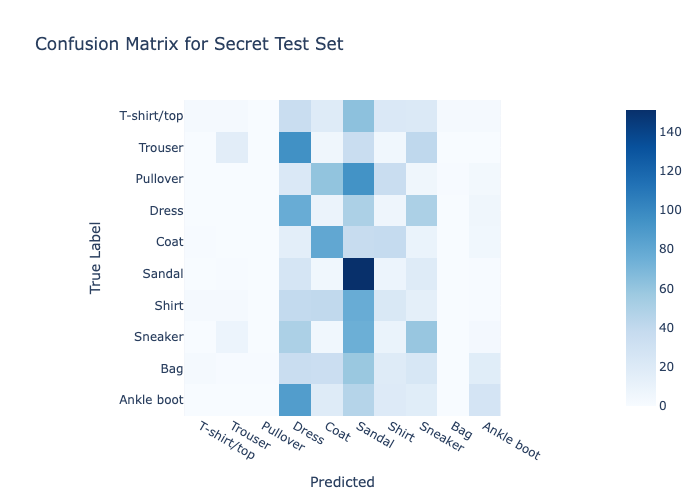

In [44]:
# TODO: plot a confusion matrix for the secret test set
# Convert labels to numeric for confusion matrix
label_to_num = {label: i for i, label in enumerate(class_names)}
y_test_secret_numeric = np.array([label_to_num[label] for label in test_secret_df['label']])
y_pred_secret_numeric = np.array([label_to_num[label] for label in test_secret_df['predicted_label']])

conf_matrix = confusion_matrix(y_test_secret_numeric, y_pred_secret_numeric, labels=list(range(10)))

# Visualize confusion matrix
fig = px.imshow(conf_matrix, 
                labels=dict(x="Predicted", y="True Label"),
                x=class_names,
                y=class_names,
                title="Confusion Matrix for Secret Test Set",
                color_continuous_scale='Blues')
fig.show()

In [45]:
grader.check("q6c")

q6c results: All test cases passed!

<!-- BEGIN QUESTION -->


### Problem 6d: Analysis of Class Accuracies and Confusion Matrix
We observe that the types of classes being misclassified differ significantly from the original test set.

**Question:** What unusual patterns do you notice in the class accuracies and confusion matrix? What might these patterns suggest about the characteristics of the test set?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## Understanding the Issue

To better understand the model's performance, let's examine some misclassifications. These are instances where the model's predictions differ from the true labels.

In the next cell, we will:
1. Identify misclassified examples from the test dataset.
2. Display these examples along with their predicted and true labels.

Pay close attention to whether the misclassifications are concentrated in specific classes or if they seem random. 

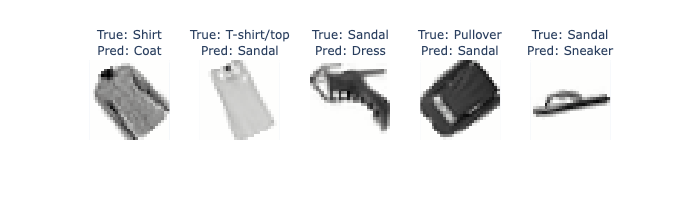

In [46]:
# Predict labels for the secret test set
predictions_secret = model.predict(X_test_secret_sc)

# Identify misclassified examples
incorrect_secret = predictions_secret != y_test_secret

# Generate labels for misclassified examples with true and predicted labels
labels = [f"True: {true_label}<br>Pred: {pred_label}"
          for true_label, pred_label in zip(y_test_secret[incorrect_secret], predictions_secret[incorrect_secret])]

# Display misclassified images with their true and predicted labels
show_images(X_test_secret[incorrect_secret], max_images=5, ncols=5, labels=labels, reshape=True)

Ah! It seems that all the test images are rotated. This misalignment between the training and test distributions is likely causing the model's poor performance on the rotated test set.

To address this issue, we can explore two potential solutions:
1. **Train a rotation-invariant classifier**: Modify the training data to include rotated images, which allows the model to learn features that are robust to rotation.
2. **Undo the rotation**: Preprocess the test images to align them with the training distribution to enable the current classifier to perform better.
3. **Use test time augmentation**: At the inference time, add augmentation to the data so the model considers augmented data at the test time. 

Let's investigate these approaches to improve the model's performance on the rotated test set.

## Problme 7: Solution 1 -- Train a Rotation-Invariant Classifier

First, let's try altering our training data to better align with the test distribution. This involves generating augmented data by applying random rotations to the training images. By doing so, we aim to train a model that is more robust to variations in orientation, which is a key characteristic of the rotated test set.

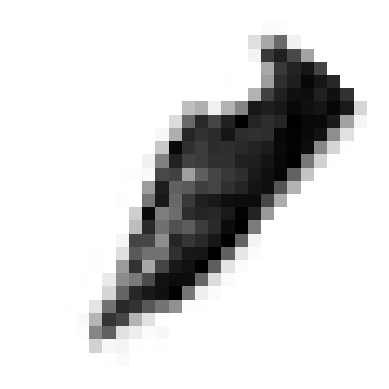

In [24]:
def rotate_image_by_angle(image, angle):
    """
    Rotate an image by a specific angle.
    """
    image = image.reshape(28, 28)  # Reshape the image to 28x28
    rotated = rotate(image, angle, reshape=False, cval=0, order=1)  # Rotate the image
    return rotated.flatten()  # Flatten the rotated image back to 1D

# Visualize a rotated image
plt.imshow(rotate_image_by_angle(X_train[0], 45).reshape(28, 28), cmap='gray_r')
plt.axis('off')
plt.show()

### Problem 7a: Generating Rotated Training Data

**Task:**
Use the provided rotation function to create augmented training data by randomly rotating the original images.

**Hints:**
- Use `NumPy`'s [random.uniform()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) to generate random rotation angles.
- Ensure the function returns two `NumPy` arrays, as `MLPClassifier` expects `NumPy` arrays as input.

(12000, 784)
(12000,)


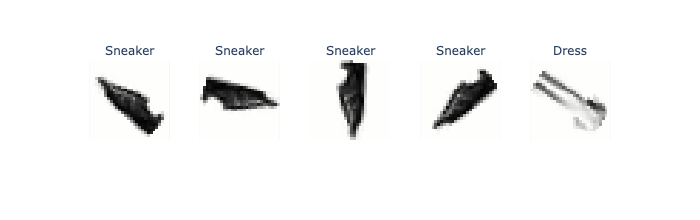

In [25]:
def randomly_rotate_images(images, num_rotations_per_image=5):
  """
  Create training data by rotating original images and storing the rotation angles as labels.
  Params:
    - images: numpy array of shape (n_images, 784)
    - num_rotations_per_image: int, number of rotations to perform per image
  Returns:
    - X_augmented: numpy array of shape (n_images * num_rotations_per_image, 784)
    - y_rotations: numpy array of shape (n_images * num_rotations_per_image,)
  """
  # TODO: Implement this function
  n_images = images.shape[0]
  X_augmented = []
  y_rotations = []
  
  for i in range(n_images):
    for _ in range(num_rotations_per_image):
      # Generate random rotation angle between -180 and 180 degrees
      angle = np.random.uniform(-180, 180)
      rotated_image = rotate_image_by_angle(images[i], angle)
      X_augmented.append(rotated_image)
      y_rotations.append(angle)
  
  return np.array(X_augmented), np.array(y_rotations)
  
X_train = X_train[:3000]
y_train = y_train[:3000]

num_rotations_per_image = 4
X_train_rotated, y_train_rotations = randomly_rotate_images(X_train, num_rotations_per_image)
y_train_augmented = np.array([y for label in y_train for y in [label]*num_rotations_per_image])
print(X_train_rotated.shape)
print(y_train_augmented.shape)

show_images(X_train_rotated, max_images=5, ncols=5, labels=y_train_augmented, reshape=True)

In [26]:
grader.check("q7a")

q7a results: All test cases passed!

### Problem 7b: Training a Rotation-Invariant Classifier

Now that we have augmented our training data with rotated images, let's train a new `MLPClassifier` on this dataset.

**Task**:
Train a new `MLPClassifier` using the rotated training images `X_train_rotated_sc` and the corresponding labels `y_train_augmented`.

**Steps**:
1. Scale the rotated training data `X_train_rotated` using the `scaler` to create `X_train_rotated_sc`.
2. Train the `MLPClassifier` on the scaled data `X_train_rotated_sc` and labels `y_train_augmented`.

**Important for grading**:
- Save your trained model as `model_rotated`.
- Use `random_state=42` when instantiating the `MLPClassifier` for reproducibility.
- Ensure your loss plot is displayed by making the plotting code the last expression in the cell or explicitly calling `plt.show()`.

**Hint**: Refer to [Scikit-learn's MLPClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) for additional guidance.

<!-- BEGIN QUESTION -->



Rotated model saved to disk.
Training accuracy (training on rotated images): 1.000
Test accuracy (original): 0.491
Test accuracy (training on rotated images): 0.668


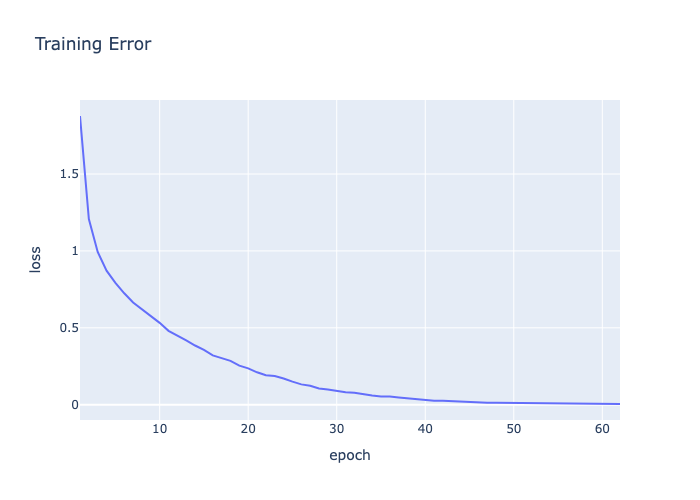

In [27]:
X_train_rotated_sc = scaler.transform(X_train_rotated)
X_test_secret_sc = scaler.transform(X_test_secret)

if load_saved_models and os.path.exists('mlp_fashionmnist_rotated_model.joblib'):
  model_rotated = joblib.load('mlp_fashionmnist_rotated_model.joblib')
  print("Rotated model loaded from disk.")
else:
  # TODO: initialize and train a new model on the rotated images
  model_rotated = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, tol=1e-3, random_state=42)
  model_rotated.fit(X_train_rotated_sc, y_train_augmented)

  if save_models:
    joblib.dump(model_rotated, "mlp_fashionmnist_rotated_model.joblib")
    print("Rotated model saved to disk.")

print(f"Training accuracy (training on rotated images): {model_rotated.score(X_train_rotated_sc, y_train_augmented):.3f}")
print(f"Test accuracy (original): {model.score(X_test_sc, y_test):.3f}")
print(f"Test accuracy (training on rotated images): {model_rotated.score(X_test_secret_sc, y_test_secret):.3f}")

loss_df = pd.DataFrame({
    'epoch': range(1, len(model_rotated.loss_curve_) + 1),
    'loss': model_rotated.loss_curve_
})
loss_df.plot(x='epoch', y='loss', title="Training Error")

In [28]:
grader.check("q7b")

q7b results: All test cases passed!

<!-- END QUESTION -->

## Problem 8: Solution 2 -- Undo the Rotations in the Secret Test Set

In this approach, we aim to align the test distribution with the training distribution by building a regression model to predict the rotation angle of an image. Once the rotation angle is predicted, we can rotate the image back to its original orientation (angle 0) before feeding it into the classifier.

### Problem 8a: Predicting Rotation Angles

**Task**:
Train a multi-layer perceptron (MLPRegressor) to predict the rotation angle of an image. Make sure you follow the same data processing steps from previous sections. We have provided the model and hyperparameters for you. 

**Instructions**:
- Save your trained MLPRegressor as `model_rotation_regressor`.
- Use `random_state=42` when instantiating your MLPRegressor to ensure reproducibility.
- If your loss plot does not display, ensure the code for plotting the loss is the *last expression* in your Jupyter cell, or explicitly call `plt.show()`.

**Hints**:
1. Refer to [Scikit-learn's MLPRegressor documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) for guidance on configuring the model.
2. Train the model for enough iterations to observe convergence. The `early_stopping` parameter can be helpful to stop training automatically once convergence is reached. If the model trains for too many iterations without converging, consider adjusting other MLPRegressor parameters.

<!-- BEGIN QUESTION -->



Iteration 1, loss = 3850.07379175
Validation score: 0.483576
Iteration 2, loss = 2519.15101256
Validation score: 0.594969
Iteration 3, loss = 2014.44060956
Validation score: 0.645622
Iteration 4, loss = 1715.94432860
Validation score: 0.680659
Iteration 5, loss = 1449.68798385
Validation score: 0.720660
Iteration 6, loss = 1279.96351732
Validation score: 0.731255
Iteration 7, loss = 1153.72900893
Validation score: 0.740906
Iteration 8, loss = 1058.88509331
Validation score: 0.747658
Iteration 9, loss = 948.20788539
Validation score: 0.761091
Iteration 10, loss = 891.01897074
Validation score: 0.752107
Iteration 11, loss = 806.26988897
Validation score: 0.771420
Iteration 12, loss = 723.30623513
Validation score: 0.773219
Iteration 13, loss = 668.62661947
Validation score: 0.776945
Iteration 14, loss = 649.21284817
Validation score: 0.763074
Iteration 15, loss = 570.37164928
Validation score: 0.782411
Iteration 16, loss = 530.16928782
Validation score: 0.791693
Iteration 17, loss = 495.

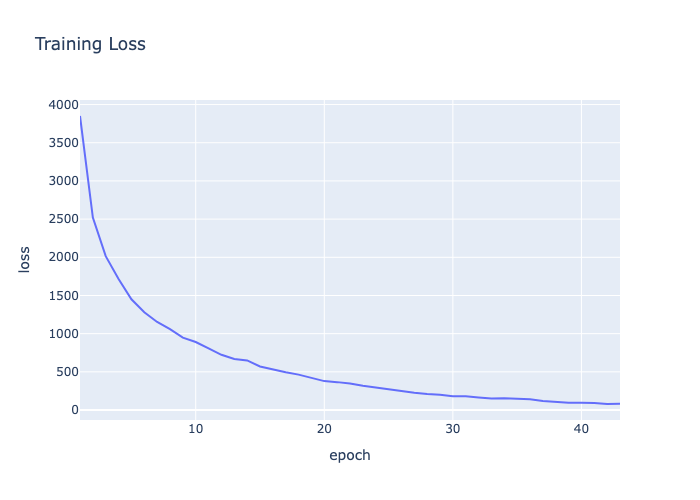

In [29]:
if (load_saved_models or IS_GRADING_ENV) and os.path.exists('model_rotation_regression.joblib'):
  model_rotation_regression = joblib.load("model_rotation_regression.joblib")
else:
  # Train a larger regression model (MLP) to predict rotation angles
  model_rotation_regression = MLPRegressor(
      hidden_layer_sizes=(256, 128),
      activation='relu',
      solver='adam',
      max_iter=100,
      random_state=SEED,
      early_stopping=True,
      verbose=True
  )
  # TODO: train a MLP regressor to predict rotation angles
  model_rotation_regression.fit(X_train_rotated_sc, y_train_rotations)
  # Save model_rotation_regression and scaler
  if save_models:
    joblib.dump(model_rotation_regression, "model_rotation_regression.joblib")
    joblib.dump(scaler, "scaler.joblib")
    print("Rotation regression model and scaler saved to disk.")

loss_df = pd.DataFrame({
    'epoch': range(1, len(model_rotation_regression.loss_curve_) + 1),
    'loss': model_rotation_regression.loss_curve_
})
loss_df.plot(x='epoch', y='loss', title="Training Loss")

In [30]:
grader.check("q8a")

q8a results: All test cases passed!

<!-- END QUESTION -->

### Problem 8b: Evaluating the Rotation Angle Prediction Model

In this task, we will evaluate the performance of our `model_rotation_regression` in predicting the rotation angles of images.

**Steps**:
1. Use the trained `model_rotation_regression` to predict the rotation angles for the images in `X_test_rotated_sc`.
2. Calculate the **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)** of the predictions.

**Hints**:
- Use the [`mean_squared_error` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) from `sklearn.metrics` to compute the MSE.
- To calculate the RMSE, take the square root of the MSE. You can use `np.sqrt()` for this purpose.

In [31]:
# TODO: Use the model_rotation_regression to predict the rotation angles on X_test_rotated_sc
# Create rotated test data similar to training data
X_test_rotated, y_test_rotations = randomly_rotate_images(X_test[:1000], num_rotations_per_image=1)
X_test_rotated_sc = scaler.transform(X_test_rotated)

y_pred_angles = model_rotation_regression.predict(X_test_rotated_sc)
mse = mean_squared_error(y_test_rotations, y_pred_angles)
rmse = np.sqrt(mse)
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f} degrees")

# Show some predictions
print("\nSample predictions:")
for i in range(5):
    print(f"True rotation: {y_test_rotations[i]:.1f}°, Predicted: {y_pred_angles[i]:.1f}°")

print("------------------------------")
print("------------------------------")
print(f"Test MSE (angle):  {mse:.2f}")
print(f"Test RMSE:        {rmse:.2f}°")
print("------------------------------")
print("------------------------------")

Test MSE: 2274.52
Test RMSE: 47.69 degrees

Sample predictions:
True rotation: 55.6°, Predicted: 36.2°
True rotation: -151.2°, Predicted: -33.9°
True rotation: -92.8°, Predicted: -72.0°
True rotation: 98.5°, Predicted: 61.4°
True rotation: 10.3°, Predicted: -12.6°
------------------------------
------------------------------
Test MSE (angle):  2274.52
Test RMSE:        47.69°
------------------------------
------------------------------


In [32]:
grader.check("q8b")

q8b results: All test cases passed!

### Relationship between the Predicted vs True Rotation Angle

Let's visualize how well `model_rotation_regression` was able to predict the true rotation angle.

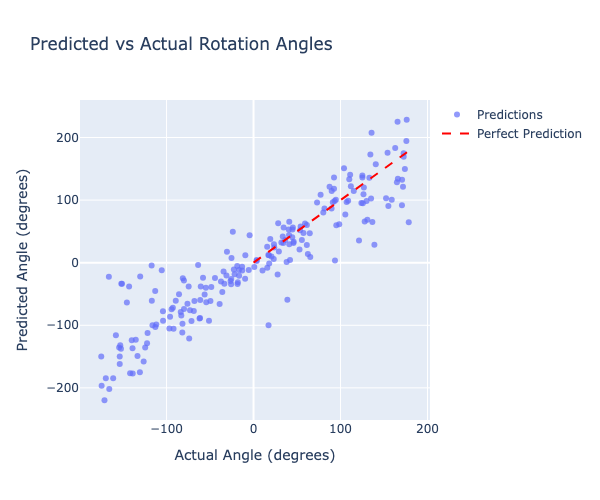

In [33]:
# Create scatter plot of predictions vs actual
scatter_fig = go.Figure()
scatter_fig.add_trace(
    go.Scatter(
        x=y_test_rotations[:200],  # First 200 samples for clarity
        y=y_pred_angles[:200],
        mode='markers',
        name='Predictions',
        marker=dict(size=6, opacity=0.7)
    )
)

# Add perfect prediction line
max_angle = max(y_test_rotations[:200])
scatter_fig.add_trace(
    go.Scatter(
        x=[0, max_angle],
        y=[0, max_angle],
        mode='lines',
        name='Perfect Prediction',
        line=dict(dash='dash', color='red')
    )
)

scatter_fig.update_layout(
    title='Predicted vs Actual Rotation Angles',
    xaxis_title='Actual Angle (degrees)',
    yaxis_title='Predicted Angle (degrees)',
    width=600,
    height=500
)

scatter_fig.show()

### Test `model_rotation_regression` in Action 
Next, let's actually try to use the rotation angles that `model_rotation_regression` predicts to unrotate the images back to their original state.

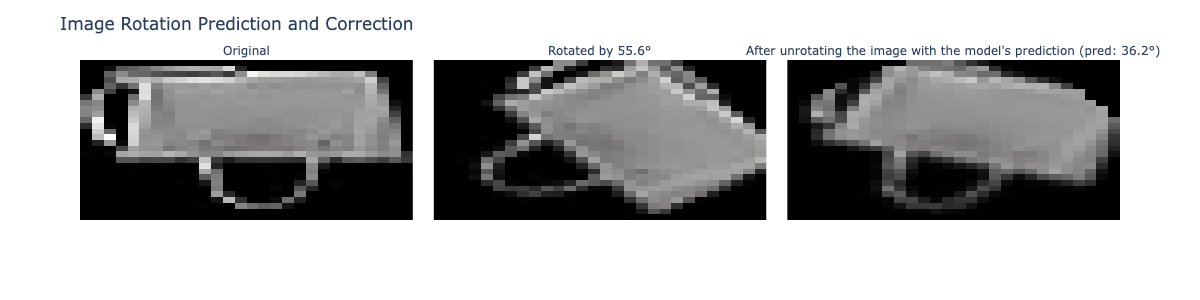

In [34]:
# Demonstrate unrotation using predicted angles
def unrotate_image(rotated_image, predicted_angle):
    """
    Unrotate an image by rotating it by the negative of the predicted angle.
    """
    return rotate_image_by_angle(rotated_image, -predicted_angle)

# Test unrotation on a sample
sample_idx = 0
original_test_image = X_test[sample_idx // 1]  # Get original unrotated image
rotated_test_image = X_test_rotated[sample_idx] # Get the rotated image
true_angle = y_test_rotations[sample_idx] # Get the true angle the image was rotated by
predicted_angle = y_pred_angles[sample_idx] # Get the model's prediction
unrotated_image = unrotate_image(rotated_test_image, predicted_angle)

# Prepare images and titles for display
images = [
    original_test_image.reshape(28, 28)[::-1],
    rotated_test_image.reshape(28, 28)[::-1],
    unrotated_image.reshape(28, 28)[::-1]
]
titles = [
    'Original',
    f'Rotated by {true_angle:.1f}°',
    f'After unrotating the image with the model\'s prediction (pred: {predicted_angle:.1f}°)'
]

# Create a subplot grid using plotly express imshow
fig = px.imshow(
    np.stack(images),
    facet_col=0,
    facet_col_wrap=3,
    color_continuous_scale='gray',
    aspect='auto'
)

# Update facet titles
for i, title in enumerate(titles):
    fig.layout.annotations[i]['text'] = title

fig.update_layout(
    height=300,
    width=1200,
    title_text="Image Rotation Prediction and Correction",
    coloraxis_showscale=False
)
fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.show()

### Problem 8c: Unrotating Images and Evaluating the Classifier

**Task:**
1. Unrotate the images in `X_test_secret` by predicting their rotation angles.

    a. Scale the secret test set `X_test_secret` using the `scaler` and save the scaled data into the variable `X_test_secret_scaled`.

    b. Use the trained `model_rotation_regression` to predict the rotation angles of the images (`y_pred_angles`).

    c. Use the predicted rotation angles to *unrotate* the images in `X_test_secret`. Save the unrotated images into `X_test_unrotated`.

    d. Scale the unrotated images using the `scaler` and save the scaled data into `X_test_unrotated_sc`.

2. Evaluate the classifier on the unrotated images.

    a. Use the original `MLPClassifier` (`model`) to make predictions on `X_test_unrotated_sc`.

    b. Check which images are correctly classified.

**Expected Output**:
- Add two new columns to `test_secret_df`:
  - `"unrotated_predictions"`: Contains the predicted classes for the unrotated images.
  - `"unrotated_correct"`: Boolean values indicating whether the predicted class matches the ground truth.

**Hints:**
- Use [scaler.transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform) to scale the data before using `model_rotation_regression` to predict rotation angles and after unrotating the images.
- Ensure that the unrotated images are properly scaled before passing them to `model` for classification.

In [35]:
# TODO: Scale the secret test set and use model_rotation_regression to unrotate the images in the secret test set
X_test_secret_scaled = scaler.transform(X_test_secret)
y_pred_angles = model_rotation_regression.predict(X_test_secret_scaled)

# Unrotate images using predicted angles
X_test_unrotated = np.array([unrotate_image(X_test_secret[i], y_pred_angles[i]) for i in range(len(X_test_secret))])
X_test_unrotated_sc = scaler.transform(X_test_unrotated)

In [37]:
grader.check("q8ci")

q8ci results: All test cases passed!

In [47]:
# TODO: Make new predictions using the original MLPClassifier model and check which images are correctly classified
test_secret_df["unrotated_prediction"] = model.predict(X_test_unrotated_sc)
test_secret_df["unrotated_correct"] = test_secret_df["unrotated_prediction"] == test_secret_df["label"]

print(f"Test accuracy: {test_secret_df.correct.mean():.3f}")
print(f"Unrotated Test accuracy: {test_secret_df.unrotated_correct.mean():.3f}")

Test accuracy: 0.217
Unrotated Test accuracy: 0.354


In [48]:
grader.check("q8cii")

q8cii results: All test cases passed!

<!-- BEGIN QUESTION -->

### Problem 8d: Comparing Data Augmentation and Rotation Correction

**Question:** Why might the rotation correction approach (Solution 2) perform worse than the data augmentation approach (Solution 1)?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

Let's compare our three strategies for handling rotated images: doing nothing (baseline), training a model on rotated data, and a two-step pipeline that predicts orientation then un-rotates before classification.

1. First, we'll make predictions using our 3 strategies.
2. Then, we'll store the accuracies of all 3 methods into a dataframe
3. Lastly, we'll plot the accuracies in a color-coded bar chart and print the accuracies.

Take a look at which method best overcomes the rotation effects.

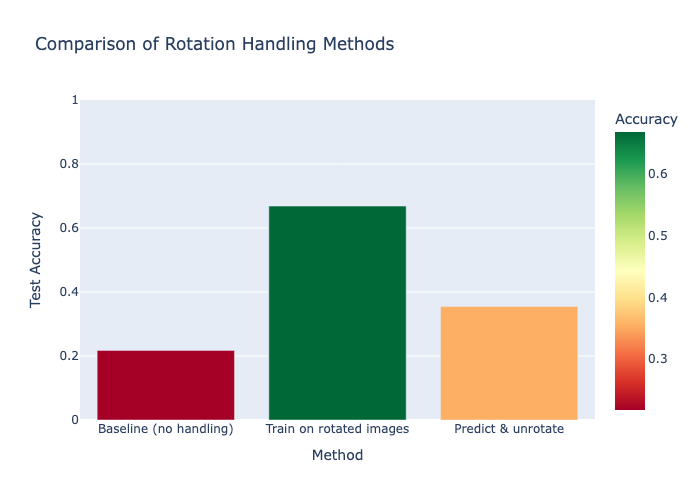


=== Summary of All Methods ===
Baseline (no handling): 0.217
Train on rotated images: 0.668
Predict & unrotate: 0.354


In [40]:
# Compare all three approaches
baseline_accuracy = model.score(X_test_secret_sc, y_test_secret) # method: baseline
rotated_training_accuracy = model_rotated.score(X_test_secret_sc, y_test_secret) # method: train on rotated images
unrotated_accuracy = model.score(X_test_unrotated_sc, y_test_secret) # method: predict & unrotate, then classify the images we tried to unrotate

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Method': ['Baseline (no handling)', 'Train on rotated images', 'Predict & unrotate'],
    'Accuracy': [baseline_accuracy, rotated_training_accuracy, unrotated_accuracy]
})

# Plot comparison
fig = px.bar(
    comparison_df,
    x='Method',
    y='Accuracy',
    title='Comparison of Rotation Handling Methods',
    color='Accuracy',
    color_continuous_scale='RdYlGn'
)
fig.update_layout(
    xaxis_title="Method",
    yaxis_title="Test Accuracy",
    yaxis=dict(range=[0, 1])
)
fig.show()

print("\n=== Summary of All Methods ===")
for _, row in comparison_df.iterrows():
    print(f"{row['Method']}: {row['Accuracy']:.3f}")

## Problem 9: Solution 3 -- Enhancing Accuracy with Test Time Augmentations

Test Time Augmentation (TTA) is a powerful technique to improve model performance during inference by applying data transformations to the test data. For example, transformations such as rotations, flips, or other augmentations can be applied to the test images before passing them to the model. The predictions from these augmented images can then be aggregated to make a more robust final prediction.

**Task:**
1. Use test time augmentations to improve the accuracy of the original classifier. Your final accuracy must reach at least **58\%**. Modify the `test_time_augmentation` function (and add any additional helper functions or transformations) as needed.

    a. You are allowed to use the rotation prediction model (`model_rotation_regression`) and can make multiple inference calls per image.

    b. You may reuse functions defined earlier in the notebook to implement your test-time augmentations.

**Important for grading**:
- You must use the original `MLPClassifier` (`model`) for classification and cannot train any additional models.

<!-- BEGIN QUESTION -->



In [41]:
# TODO: Write a function (or functions!) that can be used to improve the accuracy of the original MLPClassifer model using test time augmentations
# Feel free to add additional functions, arguments, etc. as needed!
def test_time_augmentation(model, scaler, image):
    """
    Predict a label using test-time augmentation
    Params:
        - model: the MLPClassifier model
        - scaler: the StandardScaler used to scale the images
        - image: the image to be augmented
    Returns:
        - prediction: the predicted label
    """
    # Strategy: Predict rotation angle, unrotate, then generate multiple rotations and vote
    # Step 1: Predict rotation angle and unrotate
    image_scaled = scaler.transform(image.reshape(1, -1))
    predicted_angle = model_rotation_regression.predict(image_scaled)[0]
    unrotated_image = unrotate_image(image, predicted_angle)
    
    # Step 2: Generate multiple rotations around 0 degrees (0, 90, 180, 270)
    rotations = [0, 90, 180, 270]
    predictions = []
    
    for rot_angle in rotations:
        rotated = rotate_image_by_angle(unrotated_image, rot_angle)
        rotated_scaled = scaler.transform(rotated.reshape(1, -1))
        pred = model.predict(rotated_scaled)[0]
        predictions.append(pred)
    
    # Step 3: Also try the unrotated image directly
    unrotated_scaled = scaler.transform(unrotated_image.reshape(1, -1))
    predictions.append(model.predict(unrotated_scaled)[0])
    
    # Step 4: Vote (most common prediction)
    from collections import Counter
    prediction = Counter(predictions).most_common(1)[0][0]
    
    return prediction


# Make a copy of the test secret dataframe and apply the test time augmentation to the images to get new predictions!
part_2_df = test_secret_df.copy()
part_2_df["image"] = part_2_df["image"].apply(lambda x: np.array(x).reshape(-1))
part_2_df["prediction"] = part_2_df["image"].apply(lambda x: test_time_augmentation(model, scaler, x))

# Check the accuracy of the new predictions
correct = part_2_df["prediction"] == part_2_df["label"]
print("Accuracy:", correct.mean())

NameError: name 'test_secret_df' is not defined

<!-- END QUESTION -->

# Before you submit, ensure `save_models` is true!

**Important for grading**: Make sure you set these variables to True at the top of your notebook before submitting.

In [ ]:
assert save_models and load_saved_models, "save_models and load_saved_models must be True"

assert os.path.exists('mlp_fashionmnist_model.joblib'), "mlp_fashionmnist_model.joblib should exist"
assert os.path.exists('price_model.joblib'), "price_model.joblib should exist"
assert os.path.exists('mlp_fashionmnist_rotated_model.joblib'), "mlp_fashionmnist_rotated_model.joblib should exist"
assert os.path.exists('model_rotation_regression.joblib'), "model_rotation_regression.joblib should exist"


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
## Use this cell if you are running the notebook in Google Colab to install the necessary dependencies, this may take a few minutes
if IS_COLAB:
    !apt-get install -y texlive texlive-xetex pandoc


In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True, files=['mlp_fashionmnist_model.joblib', 'price_model.joblib', 'mlp_fashionmnist_rotated_model.joblib', 'model_rotation_regression.joblib'])